<a href="https://colab.research.google.com/github/EmicoBinsfinder/GNN_Viscosity_Prediction/blob/main/DynamicViscosityPredictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Coding GNN for Molecular Property Prediction
At Google Colab with vim-mode

* Google Colab
* RDKit
* PyTorch Geometric (PyG)

Agenda
- package install & import
- data loading
- molecular graphs for pyg
- train/val/test split
- ecfp4 + random_forest
- attentive_fp
- gin & gatv2 with edge_attr

# package install & import

instal rdkit and pyg

In [129]:
!pip install rdkit-pypi

In [130]:
import torch
pyg_url = f"https://data.pyg.org/whl/torch-{torch.__version__}.html"
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f $pyg_url


Looking in links: https://data.pyg.org/whl/torch-2.0.1+cu118.html


In [131]:
!git clone https://github.com/EmicoBinsfinder/GNN_Viscosity_Prediction.git

fatal: destination path 'GNN_Viscosity_Prediction' already exists and is not an empty directory.


import

In [132]:
import sys
import urllib.request
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from tqdm.notebook import tqdm

from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.Draw import IPythonConsole

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, Subset

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_networkx


In [133]:
!curl -O https://raw.githubusercontent.com/itakigawa/mpl_rdkit_utils/main/mpl_rdkit_utils.py

from mpl_rdkit_utils import DrawMolToMPL

def plot_mol_graph(graph, figsize=(8, 4), edge_label=True):
  g = to_networkx(graph, to_undirected=True)
  edge_dict = defaultdict(list)
  for i, e in enumerate(zip(*graph.edge_index.tolist())):
    u, v = e
    edge_dict[(u, v)].append(i)
    edge_dict[(v, u)].append(i)
  labels = {e: "{},{}".format(*edge_dict[e]) for e in g.edges}

  mol = graph.mol
  AllChem.Compute2DCoords(mol)
  pos = mol.GetConformers()[0].GetPositions()[:,:2]

  fig, ax = plt.subplots(1, 2, figsize=figsize)
  node_size=300
  nx.draw_networkx(g, pos, ax=ax[0], node_color='#eee', \
                   node_size=node_size, edgecolors='k')
  if edge_label:
    nx.draw_networkx_edge_labels(g, pos, ax=ax[0], edge_labels=labels,\
                                font_color='blue', rotate=False)
  dpi = plt.rcParams["figure.dpi"]
  node_radius = (node_size / 3.14159265359)**0.5 / dpi
  ax[0].set_axis_off()
  ax[0].set_aspect('equal')
  xmin, xmax = ax[0].get_xlim()
  ymin, ymax = ax[0].get_ylim()
  fs = min(*figsize)
  xr = node_radius * fs
  yr = node_radius * fs
  ax[0].set_xlim(xmin-xr, xmax+xr)
  ax[0].set_ylim(ymin-yr, ymax+yr)

  (xmin, xmax), (ymin, ymax) = DrawMolToMPL(mol, fig, ax[1])
  ax[1].set_xlim(xmin, xmax)
  ax[1].set_ylim(ymin, ymax)
  ax[1].get_xaxis().set_visible(False)
  ax[1].get_yaxis().set_visible(False)
  plt.tight_layout()
  plt.show()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7540  100  7540    0     0  25443      0 --:--:-- --:--:-- --:--:-- 25387


# data loading

In [134]:
df = pd.read_csv('/content/GNN_Viscosity_Prediction/Dataset.csv')

In [135]:
ID_list = list(range(len(df)))
df['ID'] = ID_list
df = df.rename(columns = {'0':'id'})
df = df[['smiles', 'ID', 'DVI']]
df = df.dropna()
df = df.drop_duplicates()
df.to_csv('input.csv')

In [136]:
df.head()
len(df)

54338

In [137]:
df = pd.read_csv('input.csv', index_col=0)
smi = df['smiles'][9314]
mol = Chem.MolFromSmiles(smi)

In [138]:
smi

'COCOCC=CCCC=CCCCCOC(C=Cc1ccccc1)OCc1ccccc1'

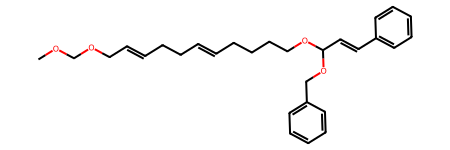

In [139]:
mol

In [140]:
df.shape

(54338, 3)

# molecular graphs for pyg

In [141]:
edges = []
for bond in mol.GetBonds():
  i = bond.GetBeginAtomIdx()
  j = bond.GetEndAtomIdx()
  edges.extend([(i,j), (j,i)])

In [142]:
edge_index = list(zip(*edges))

In [ ]:
edge_index

In [144]:
def atom_feature(atom):
  return [atom.GetAtomicNum(),
          atom.GetDegree(),
          atom.GetNumImplicitHs(),
          atom.GetIsAromatic()]

def bond_feature(bond):
  return [bond.GetBondType(),
          bond.GetStereo()]

In [145]:
node_features = [atom_feature(a) for a in mol.GetAtoms()]
edge_features = [bond_feature(b) for b in mol.GetBonds()]

In [146]:
g = Data(edge_index=torch.LongTensor(edge_index),
         x=torch.FloatTensor(node_features),
         edge_attr=torch.FloatTensor(edge_features),
         smiles=smi,
         mol=mol)

In [147]:
g

Data(x=[33, 4], edge_index=[2, 68], edge_attr=[34, 2], smiles='COCOCC=CCCC=CCCCCOC(C=Cc1ccccc1)OCc1ccccc1', mol=<rdkit.Chem.rdchem.Mol object at 0x7be708752420>)

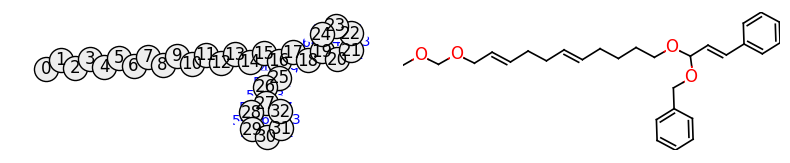

In [148]:
plot_mol_graph(g)

In [149]:
def smi_to_pyg(smi, y):
    mol = Chem.MolFromSmiles(smi)
    if mol is None:
      return None

    id_pairs = ((b.GetBeginAtomIdx(), b.GetEndAtomIdx()) for b in mol.GetBonds())
    atom_pairs = [z for (i, j) in id_pairs for z in ((i, j), (j, i))]

    bonds = (mol.GetBondBetweenAtoms(i, j) for (i, j) in atom_pairs)
    atom_features = [atom_feature(a) for a in mol.GetAtoms()]
    bond_features = [bond_feature(b) for b in bonds]

    return Data(edge_index=torch.LongTensor(list(zip(*atom_pairs))),
                x=torch.FloatTensor(atom_features),
                edge_attr=torch.FloatTensor(bond_features),
                y=torch.LongTensor([y]),
                mol=mol,
                smiles=smi)

In [150]:
class MyDataset(Dataset):
  def __init__(self, smiles, response):
    mols = [smi_to_pyg(smi, y) for smi, y in \
            tqdm(zip(smiles, response), total=len(smiles))]
    self.X = [m for m in mols if m]

  def __getitem__(self, idx):
    return self.X[idx]

  def __len__(self):
    return len(self.X)

In [151]:
base_dataset = MyDataset(df['smiles'].head(5000), df['DVI'].head(5000))

  0%|          | 0/5000 [00:00<?, ?it/s]

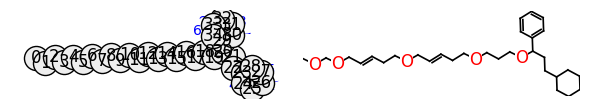

In [152]:
g = base_dataset[8]
plot_mol_graph(g, figsize=(6, 3), edge_label=True)

In [153]:
g

Data(x=[35, 4], edge_index=[2, 72], edge_attr=[72, 2], y=[1], mol=<rdkit.Chem.rdchem.Mol object at 0x7be708bfb290>, smiles='COCOCC=CCCOCC=CCCOCCCOC(CCC1CCCCC1)c1ccccc1')

In [ ]:
g.x

In [ ]:
g.edge_attr

In [ ]:
g.edge_index

# train/val/test split

In [157]:
N = len(base_dataset)
M = N // 10

indices = np.random.permutation(range(N))

idx = {'train': indices[:8*M],
      'valid': indices[8*M:9*M],
      'test': indices[9*M:]}

modes = ['train', 'valid', 'test']

In [158]:
dataset = {m: Subset(base_dataset, idx[m]) for m in modes}
loader = {m: DataLoader(dataset[m], batch_size=2, shuffle=True) if m == 'train' \
          else DataLoader(dataset[m], batch_size=2) for m in modes}

# gin & gatv2 with edge_attr

In [159]:
from torch_geometric.nn import GINEConv, GATv2Conv, global_add_pool

In [160]:
def MyConv(node_dim, edge_dim, arch='GIN'):
  conv = None
  if arch == 'GIN':
    h = nn.Sequential(nn.Linear(node_dim, node_dim, bias=True))
    conv = GINEConv(h, edge_dim=edge_dim)
  elif arch == 'GAT':
    conv = GATv2Conv(node_dim, node_dim, edge_dim=edge_dim)
  return conv

In [161]:
class MyGNN(nn.Module):
  def __init__(self, node_dim, edge_dim, arch, num_layers=3):
    super().__init__()
    layers = [MyConv(node_dim, edge_dim, arch) for _ in range(num_layers)]
    self.convs = nn.ModuleList(layers)

  def forward(self, x, edge_index, edge_attr):
    for conv in self.convs:
      x = conv(x, edge_index, edge_attr)
      x = F.leaky_relu(x)
    return x

In [162]:
[int(x) for x in Chem.rdchem.BondType.names.values()]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]

In [163]:
ptable = Chem.GetPeriodicTable()
for i in range(200):
  try:
    s = ptable.GetElementSymbol(i)
  except:
    print(f'max id {i-1} for {s}')
    break
ptable.GetElementSymbol(i-1)

max id 118 for Og


[17:37:23] 

****
Pre-condition Violation
Atomic number not found
Violation occurred on line 99 in file /project/build/temp.linux-x86_64-cpython-310/rdkit/Code/GraphMol/PeriodicTable.h
Failed Expression: atomicNumber < byanum.size()
****



'Og'

In [164]:
class MyFinalNetwork(nn.Module):
  def __init__(self, node_dim, edge_dim, arch, num_layers=3,
               encoding='onehot'):
    super().__init__()

    self.encoding = encoding
    if encoding != 'onehot':
      self.atom_encoder = nn.Embedding(num_embeddings=118+1, embedding_dim=64)
      self.bond_encoder = nn.Embedding(num_embeddings=21+1, embedding_dim=8)
      node_dim = (node_dim-1) + 64
      edge_dim = (edge_dim-1) + 8
    else:
      node_dim = (node_dim-1) + 118+1
      edge_dim = (edge_dim-1) + 21+1

    self.gnn = MyGNN(node_dim, edge_dim, arch, num_layers=num_layers)
    embed_dim = int(node_dim / 2)
    self.head = nn.Sequential(
        nn.BatchNorm1d(node_dim),
        nn.Dropout(p=0.5),
        nn.Linear(node_dim, embed_dim, bias=True),
        nn.ReLU(),
        nn.BatchNorm1d(embed_dim),
        nn.Dropout(p=0.5),
        nn.Linear(embed_dim, 1)
    )
  def forward(self, x, edge_index, edge_attr, batch):
    if self.encoding == 'onehot':
      x0 = F.one_hot(x[:, 0].to(torch.int64), num_classes=118+1)
      edge_attr0 = F.one_hot(edge_attr[:, 0].to(torch.int64), num_classes=21+1)
    else:
      x0 = self.atom_encoder(x[:, 0].int())
      edge_attr0 = self.bond_encoder(edge_attr[:, 0].int())

    x = torch.cat([x0, x[:, 1:]], dim=1)
    edge_attr = torch.cat([edge_attr0, edge_attr[:, 1:]], dim=1)

    node_out = self.gnn(x, edge_index, edge_attr)
    graph_out = global_add_pool(node_out, batch)
    return self.head(graph_out)

In [165]:
node_dim = base_dataset[0].num_node_features
edge_dim = base_dataset[0].num_edge_features
node_dim, edge_dim

(4, 2)

In [166]:
model = MyFinalNetwork(node_dim, edge_dim, arch='GAT', num_layers=3, encoding='embedding')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
device

device(type='cuda')

In [167]:
train_epochs = 200
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, \
                                                steps_per_epoch=len(loader['train']),
                                                epochs=train_epochs)
criterion = nn.MSELoss()

In [168]:
def train(loader):
    total_loss = total_examples = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        loss = criterion(out, data.y.float())
        loss.backward()
        optimizer.step()
        scheduler.step()
        total_loss += loss.item()
        total_examples += data.num_graphs
    return total_loss / total_examples

@torch.no_grad()
def test(loader):
    total_loss = total_examples = 0
    for data in loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        loss = criterion(out, data.y.float())
        total_loss += loss.item()
        total_examples += data.num_graphs
    return total_loss / total_examples

@torch.no_grad()
def predict(loader):
    y_pred = []
    y_true = []
    for data in loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        _, predicted = torch.max(out.data, 1)
        y_true.extend(data.y.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
    return y_true, y_pred

In [ ]:
best_val = float("inf")

learn_curve = defaultdict(list)
func = {'train': train, 'valid': test, 'test': test}

for epoch in tqdm(range(1, train_epochs+1)):
    loss = {}
    for mode in ['train', 'valid', 'test']:
      loss[mode] = func[mode](loader[mode])
      learn_curve[mode].append(loss[mode])
    if loss['valid'] < best_val:
      torch.save(model.state_dict(), 'best_val.model')
    if epoch % 2 == 0:
      print(f'Epoch: {epoch:03d} Loss: ' + ' '.join(
          ['{} {:.6f}'.format(m, loss[m]) for m in modes]
      ))

  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 002 Loss: train 11500.807555 valid 11443.349801 test 11452.138937
Epoch: 004 Loss: train 11335.847300 valid 11237.088891 test 11257.984988
Epoch: 006 Loss: train 10949.025327 valid 10782.730848 test 10760.396711
Epoch: 008 Loss: train 10055.728662 valid 9699.835852 test 9743.106863
Epoch: 010 Loss: train 8331.578539 valid 7727.976418 test 7739.032309
Epoch: 012 Loss: train 5580.448837 valid 4676.756734 test 4692.230379
Epoch: 014 Loss: train 2340.169627 valid 1576.381560 test 1675.481171
Epoch: 016 Loss: train 511.046418 valid 429.204292 test 413.926166
Epoch: 018 Loss: train 401.969265 valid 363.712298 test 367.361589
Epoch: 020 Loss: train 375.926006 valid 362.079889 test 396.055489
Epoch: 022 Loss: train 369.560121 valid 325.636195 test 363.527748
Epoch: 024 Loss: train 354.104650 valid 379.016749 test 334.977073
Epoch: 026 Loss: train 349.695103 valid 351.968094 test 352.583729
Epoch: 028 Loss: train 339.538219 valid 332.603340 test 363.805831
Epoch: 030 Loss: train 340.0701

In [ ]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_auc_score

In [ ]:
fig, ax = plt.subplots()
for m in modes:
  ax.plot(learn_curve[m], label=m)
ax.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('loss')
ax.set_yscale('log')
plt.show()

In [ ]:
model.load_state_dict(torch.load('best_val.model'))

for m in ['valid', 'test']:
  y_true, y_pred = predict(loader[m])
  for metric in [accuracy_score, balanced_accuracy_score, roc_auc_score]:
    print("{} {} {:.3f}".format(m, metric.__name__, metric(y_true, y_pred)))

# finalize

link:
https://itakigawa.page.link/test_proj